Build a Generative Adversarial Network (GAN) model to generate handwritten digits. Deep Convolitional GAN (DCGAN) is used.

Code for this project comprises -- parts:
1. Set seed.
2. Configurations
3. Dataset : load & into batches (dataloader)








In [2]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(32)

Configurations

In [3]:
device = 'cuda'
batch_size = 128

noise_dim = 64 #shape of the random noise vector in the generator

# Optimizer parameters
lr = 0.002
beta_1 = 0.5
beta_2 = 0.999

# Training Parameters
epochs = 20

# Load Dataset

In [4]:
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader

train_aug = T.Compose([
    T.ToTensor(),
    T.RandomRotation((-20,20))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=train_aug)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15754331.09it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 489300.74it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4379491.42it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10613107.95it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



(Debug) Visualize training images

In [5]:
img,label = trainset[5]
print(img.shape)
print(label)

torch.Size([1, 28, 28])
2


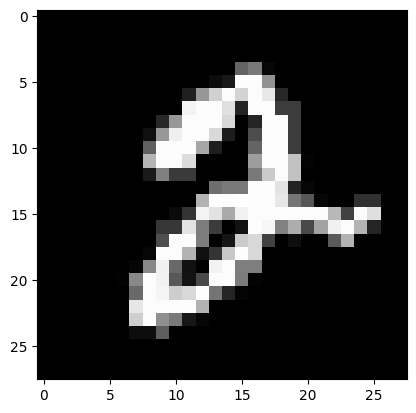

In [6]:
plt.imshow(img.squeeze(), cmap='gray')
plt.imsave('img1.png',img.squeeze(), cmap='gray')

plt.show()

(Debug) Iterate through dataset batches & Display a grid of images

In [7]:
images, labels = next(iter(trainloader))
print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


batch_size is 128. Image size: 28 x 28

In [12]:
# show_images_grid: function used to plot some images from the batch as a grid

from torchvision.utils import make_grid
def show_tensorImages_grid(images,num_images=16):
  unflat_img = images.detach().cpu()
  img_grid = make_grid(unflat_img[:num_images],nrow=4)
  plt.imshow(img_grid.permute(1,2,0).squeeze()) #channel dimension has to be moved to end: for matplotlib
  plt.show()

In [13]:
from torchvision.utils import save_image
save_image(images[:36],'checkf.png',nrow=6)

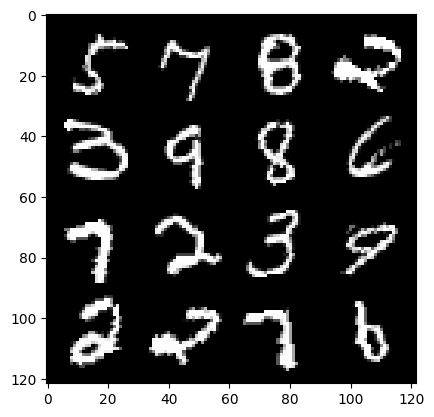

In [13]:
show_tensorImages_grid(images,16)

# Create Discriminator network

In [11]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [12]:
import torch.nn as nn
from torchsummary import summary

In [13]:
def disc_block(in_channels, out_channels, kernel_size, stride=2):
  block = nn.Sequential(nn.Conv2d(in_channels, out_channels,kernel_size,stride),
                        nn.BatchNorm2d(out_channels),
                        nn.LeakyReLU(0.2))
  return block


In [14]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.block1 = disc_block(1,16,(3,3))
    self.block2 = disc_block(16,32,(5,5))
    self.block3 = disc_block(32,64,(5,5))

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(64,1)

  def forward(self,x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.flatten(x)
    x = self.linear(x) # NB: we are not using sigmoid output layer: since BCEwithLogitsLoss() has sigmoid and BCE loss in a single layer which provides better stability.
    return x

Initialise discriminator class and double-check dimensions of each layer.

In [15]:
D = Discriminator().to(device)
summary(D,input_size=(1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [16]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [17]:
def get_generator_block(in_channels,out_channels,kernel_size,stride,final_block = False):
  if final_block:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [18]:
class Generator(nn.Module):
  def __init__(self,z_dim):
    super().__init__()
    self.z_dim = z_dim

    self.block1 = get_generator_block(z_dim,256,(3,3),2)
    self.block2 = get_generator_block(256,128,(4,4),1)
    self.block3 = get_generator_block(128,64,(3,3),2)

    self.block4 = get_generator_block(64,1,(4,4),2,final_block=True)

  def forward(self,r_noise_vec):
    # (bs,noise_dim) -> (bs,noise_dim,1)
    x = r_noise_vec.view(-1,self.z_dim,1,1) #reshape random noise vector
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    return x

In [19]:
G = Generator(noise_dim).to(device)
summary(G,input_size=(noise_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [20]:
#Replace random initialized weights to Normal weights
def weights_init(m):
  if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
    nn.init.normal_(m.weight,0.0,0.02)
  if isinstance(m,nn.BatchNorm2d):
    nn.init.normal_(m.weight,0.0,0.02)
    nn.init.constant_(m.bias,0) # all set to 0

In [21]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Loss function and Optimizer

In [31]:
# Fake loss
def get_fake_loss(disc_out):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_out)
  return criterion(disc_out,ground_truth)

# real loss
def get_real_loss(disc_out):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_out)
  return criterion(disc_out,ground_truth)

In [24]:
# Optimizer
G_opt = torch.optim.Adam(G.parameters(),lr=lr,betas=(beta_1,beta_2))
D_opt = torch.optim.Adam(D.parameters(),lr=lr,betas=(beta_1,beta_2))

# Training Loop

In [2]:
from tqdm import tqdm
for i in range(epochs):
  # for each epoch:
  total_d_loss = 0.0
  total_g_loss = 0.0
  for real_img, _ in tqdm(trainloader): #tqdm is used to show the progress bar for loop execution
    # for each mini-batch:
    real_img = real_img.to(device) # move to GPU

    # Train Discriminator
    D_opt.zero_grad() # set D gradients to 0

    random_noise_vec = torch.randn(batch_size,noise_dim,device=device)
    gen_img = G(random_noise_vec)
    gen_Dout = D(gen_img)
    fake_loss = get_fake_loss(gen_Dout)

    real_Dout = D(real_img)
    real_loss = get_real_loss(real_Dout)

    d_loss = (real_loss + fake_loss)/2
    total_d_loss += d_loss.item()
    d_loss.backward()
    D_opt.step()

    # Train Generator
    G_opt.zero_grad() # set G gradients to zero

    random_noise_vec = torch.randn(batch_size,noise_dim,device=device)
    gen_img = G(random_noise_vec)
    gen_Dout = D(gen_img)
    g_loss = get_real_loss(gen_Dout)

    total_g_loss += g_loss.item()
    g_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss/len(trainloader) # computed after each epoch
  avg_g_loss = total_g_loss/len(trainloader)

  print('Epoch: {} | D_loss: {} | G_loss: {}'.format(i+1,avg_d_loss,avg_g_loss))
  show_tensorImages_grid(gen_img,16)

NameError: name 'epochs' is not defined

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensorImages_grid(generated_image)